In [1]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd
import estimation_assessment.scores as es_as

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
from vicon_imu_data_process.dataset import *

from estimation_models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

from estimation_study import *
from estimation_assessment.visualization import *
#import pdb
import re

tensorflow version: 2.5.0
tensorflow version: 2.5.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')] []


In [4]:
subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'4subjects_kam_norm_landing_data.hdf5'))

In [21]:
subjects_trials_dataset.keys()
subjects_trials_dataset['P_14_hunan']['03']

,TIME,CHEST_Accel_X,CHEST_Accel_Y,CHEST_Accel_Z,CHEST_Gyro_X,CHEST_Gyro_Y,CHEST_Gyro_Z,WAIST_Accel_X,WAIST_Accel_Y,WAIST_Accel_Z,...,L_SHANK_Gyro_X,L_SHANK_Gyro_Y,L_SHANK_Gyro_Z,L_FOOT_Accel_X,L_FOOT_Accel_Y,L_FOOT_Accel_Z,L_FOOT_Gyro_X,L_FOOT_Gyro_Y,L_FOOT_Gyro_Z,R_KNEE_MOMENT_X
0,-1.710534,-0.424995,-0.734135,0.686836,-0.941156,-1.793747,-1.875758,0.453011,-0.757925,1.132857,...,-0.038802,0.170476,2.602978,-0.796255,-0.185990,-1.185303,-0.252640,-0.055264,1.078100,-0.626705
1,-1.667229,-0.143158,-0.851710,0.798067,-1.112133,-1.729047,-1.802138,0.359439,-0.856512,1.138550,...,-0.030999,0.287858,2.550471,-0.450584,0.258639,-1.109548,0.055189,-0.020982,0.837551,-0.634209
2,-1.623924,0.251877,-0.959735,0.902417,-1.274221,-1.564709,-1.706937,0.191356,-0.901610,1.143534,...,0.019603,0.465052,2.481428,-0.114177,0.648061,-1.002138,0.338500,-0.088114,0.720206,-0.637870
3,-1.580620,0.677736,-1.040872,1.001879,-1.410109,-1.300051,-1.644073,0.021089,-0.896615,1.148802,...,0.127398,0.642702,2.400837,0.117437,1.012927,-0.870764,0.562303,-0.264127,0.724805,-0.639091
4,-1.537315,1.042865,-1.082248,1.098880,-1.511785,-0.952943,-1.644114,-0.088139,-0.855691,1.154692,...,0.284002,0.749009,2.309075,0.197114,1.356139,-0.741760,0.700168,-0.542077,0.826765,-0.639400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.537315,0.345947,-0.571723,0.207315,-1.450393,-0.920136,0.167477,-0.021199,-0.287875,0.472148,...,0.383391,-0.115514,0.309276,0.504691,-0.122733,0.289687,0.234056,-0.194243,-0.043042,-0.557779
76,1.580620,0.318239,-0.563917,0.223919,-1.454620,-0.997521,0.165463,0.007676,-0.304269,0.449416,...,0.392527,-0.128097,0.304935,0.472935,-0.114327,0.283047,0.235741,-0.192944,-0.042837,-0.560812
77,1.623924,0.293563,-0.553613,0.219142,-1.452560,-1.062811,0.165606,0.005818,-0.313200,0.411314,...,0.389660,-0.173597,0.286746,0.429987,-0.104431,0.277292,0.234858,-0.195706,-0.033000,-0.567907
78,1.667229,0.276056,-0.540862,0.192503,-1.441610,-1.114244,0.170209,-0.040027,-0.312501,0.356620,...,0.370000,-0.232470,0.244632,0.403333,-0.101121,0.275052,0.231446,-0.202404,-0.014073,-0.583089


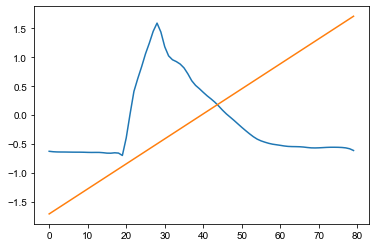

In [16]:
plt.plot(subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'])
plt.plot(subjects_trials_dataset['P_14_hunan']['03']['TIME'])

In [18]:
all_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'all_subjects_landing_data.hdf5'))
all_subjects_trials_dataset.keys()


dict_keys(['P_08_zhangboyuan', 'P_09_libang', 'P_10_dongxuan', 'P_11_liuchunyu', 'P_12_fuzijun', 'P_13_xulibang', 'P_14_hunan', 'P_15_liuzhaoyu', 'P_16_zhangjinduo', 'P_17_congyuanqi', 'P_18_hezhonghai', 'P_19_xiongyihui', 'P_20_xuanweicheng', 'P_21_wujianing', 'P_22_zhangning', 'P_23_wangjinhong', 'P_24_liziqing'])

    CHEST_Accel_X  CHEST_Accel_Y  CHEST_Accel_Z  CHEST_Gyro_X  CHEST_Gyro_Y  \
0       -1.387034       2.796255      -0.943298     -1.012042     -0.593076   
1       -0.788792       1.650273      -0.432814     -1.190595     -0.571663   
2        0.049729       0.597362       0.046089     -1.359866     -0.517272   
3        0.953678      -0.193470       0.502562     -1.501775     -0.429679   
4        1.728718      -0.596759       0.947735     -1.607957     -0.314797   
..            ...            ...            ...           ...           ...   
75       0.249407       4.379273      -3.144011     -1.543844     -0.303939   
76       0.190592       4.455357      -3.067809     -1.548259     -0.329551   
77       0.138214       4.555784      -3.089730     -1.546108     -0.351160   
78       0.101052       4.680064      -3.211987     -1.534672     -0.368183   
79       0.076490       4.832594      -3.419622     -1.508967     -0.383165   

    CHEST_Gyro_Z  CHEST_Mag_X  CHEST_Mag_Y  CHEST_M

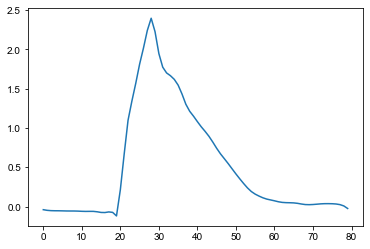

In [22]:

print(all_subjects_trials_dataset['P_14_hunan']['03'])
plt.plot(all_subjects_trials_dataset['P_14_hunan']['03']['R_KNEE_MOMENT_X'])

In [35]:
v2_augment_subjects_trials_dataset = pro_rd.load_subjects_dataset(h5_file_name = os.path.join(DATA_PATH,'v2_2_5d_augment_kam_norm_landing_data.hdf5'))
#print(subjects_trials_dataset['P_08_zhangboyuan'].keys())
v2_augment_subjects_trials_dataset['P_08_zhangboyuan']['01_17']

,CHEST_Accel_X,CHEST_Accel_Y,CHEST_Accel_Z,CHEST_Gyro_X,CHEST_Gyro_Y,CHEST_Gyro_Z,WAIST_Accel_X,WAIST_Accel_Y,WAIST_Accel_Z,WAIST_Gyro_X,...,L_SHANK_Gyro_Y,L_SHANK_Gyro_Z,L_FOOT_Accel_X,L_FOOT_Accel_Y,L_FOOT_Accel_Z,L_FOOT_Gyro_X,L_FOOT_Gyro_Y,L_FOOT_Gyro_Z,TIME,R_KNEE_MOMENT_X
0,-0.307743,-0.848483,0.886402,0.201739,0.832931,0.105811,-0.409672,-0.812233,1.219347,-0.198479,...,2.015743,1.318920,0.007890,0.214291,-0.785808,0.429048,0.295970,2.494976,-1.710534,-0.681864
1,-0.280371,-0.802816,0.910427,0.093627,0.909836,0.041653,-0.465538,-0.866906,1.214529,-0.323971,...,1.773624,1.277570,-0.293376,0.304545,-0.716163,0.365726,0.239581,2.377982,-1.667229,-0.680241
2,-0.244814,-0.774021,0.932067,-0.034777,1.001446,-0.023239,-0.396340,-0.895519,1.198755,-0.399684,...,1.428282,1.243045,-0.618836,0.289109,-0.761043,0.267304,0.078228,2.204453,-1.623924,-0.679721
3,-0.198346,-0.760491,0.951081,-0.182230,1.079027,-0.081435,-0.227489,-0.894633,1.179919,-0.439617,...,1.038673,1.210406,-0.950486,0.218353,-0.899204,0.184937,-0.161500,1.963400,-1.580620,-0.682034
4,-0.135312,-0.757351,0.966908,-0.341787,1.115470,-0.128699,-0.006415,-0.867088,1.165251,-0.464982,...,0.664248,1.170919,-1.246950,0.150590,-1.085972,0.147702,-0.440947,1.657702,-1.537315,-0.685047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.257972,-0.011182,1.133225,-0.240339,0.062359,0.207354,0.574025,-0.042988,0.564440,-0.109085,...,-0.121612,-0.045492,0.296214,-0.262877,0.444766,0.206899,-0.125350,-0.158966,1.537315,-0.343186
76,0.193218,-0.036154,1.121625,-0.263476,0.030059,0.221108,0.580499,-0.065291,0.558010,-0.068496,...,-0.077985,-0.053130,0.301120,-0.265009,0.442733,0.199733,-0.131683,-0.150144,1.580620,-0.353327
77,0.127517,-0.056372,1.109515,-0.268156,0.006586,0.222826,0.571514,-0.079616,0.539181,-0.021621,...,-0.036555,-0.063215,0.313075,-0.269360,0.440253,0.193788,-0.134216,-0.142295,1.623924,-0.360142
78,0.067892,-0.071170,1.097860,-0.254249,-0.007835,0.216033,0.549768,-0.084547,0.509169,0.025668,...,-0.013909,-0.073312,0.328938,-0.275995,0.437672,0.189357,-0.131502,-0.137383,1.667229,-0.366597


In [45]:
sub = list(v2_augment_subjects_trials_dataset.keys())

In [52]:
sub

['P_10_dongxuan',
 'P_11_liuchunyu',
 'P_13_xulibang',
 'P_14_hunan',
 'P_15_liuzhaoyu',
 'P_16_zhangjinduo',
 'P_17_congyuanqi',
 'P_18_hezhonghai',
 'P_19_xiongyihui',
 'P_20_xuanweicheng',
 'P_21_wujianing',
 'P_22_zhangning',
 'P_23_wangjinhong',
 'P_24_liziqing']